In [68]:
import torch
print(torch.cuda.is_available())

True


In [69]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [71]:
train_dir = r'/home/rc/Desktop/dataset/train'
test_dir = r'/home/rc/Desktop/dataset/test'

In [72]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle = True,
        num_workers = num_workers,
        pin_memory=True,
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle = False,
        num_workers = num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names



In [73]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manually created transforms: {manual_transforms}')


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [74]:
BATCH_SIZE = 16

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x70a312b45480>,
 ['Common Lanthana',
  'Hibiscus',
  'Jatropha',
  'Marigold',
  'Rose',
  'champaka',
  'chitrak',
  'honeysuckle',
  'indian mallow',
  'malabar melastome',
  'shankupushpam',
  'spider lily',
  'sunflower'])

torch.Size([3, 224, 224]) tensor(3)


(-0.5, 223.5, 223.5, -0.5)

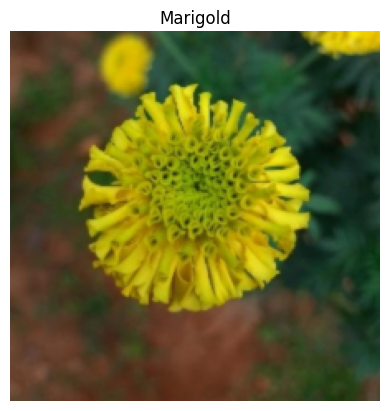

In [75]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [76]:
class PatchEmbedding(nn.Module):
    
    def __init__(self,
                in_channels: int=3,
                patch_size: int=8,
                embedding_dim: int=192):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                 end_dim=3)
        
    def forward(self,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0,  f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0,2,1)
    

In [77]:
patch_size = 8

def set_seeds(seed: int=42):
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=8,
                          embedding_dim=192)

print(f'Input image shape: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Output patch embedding shape: {patch_embedded_image.shape}')

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 784, 192])


In [78]:
print(patch_embedded_image)
print(f'Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]')

tensor([[[-0.0916, -0.2844,  0.0321,  ...,  0.0963, -0.0259,  0.1298],
         [-0.0719, -0.2733,  0.0491,  ...,  0.0816, -0.0337,  0.0929],
         [-0.1049, -0.3388,  0.0099,  ...,  0.1100, -0.0424,  0.1343],
         ...,
         [-0.1715, -0.1820,  0.0471,  ...,  0.0586,  0.0359,  0.0482],
         [-0.1693, -0.2707,  0.0350,  ...,  0.0656, -0.0285,  0.0821],
         [-0.1591, -0.3392,  0.0078,  ...,  0.1025, -0.0167,  0.1709]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 784, 192]) -> [batch_size, number_of_patches, embedding_dimension]


In [79]:
set_seeds()

patch_size = 8

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=192)

patch_embedding = patch_embedding_layer(x)f
print(f"Patching embedding shape: {patch_embedding.shape}")



batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) 


patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 784, 192])
Class token embedding shape: torch.Size([1, 1, 192])
Patch embedding with class token shape: torch.Size([1, 785, 192])
Patch and position embedding shape: torch.Size([1, 785, 192])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0916, -0.2844,  0.0321,  ...,  0.0963, -0.0259,  0.1298],
         [-0.0719, -0.2733,  0.0491,  ...,  0.0816, -0.0337,  0.0929],
         ...,
         [-0.1715, -0.1820,  0.0471,  ...,  0.0586,  0.0359,  0.0482],
         [-0.1693, -0.2707,  0.0350,  ...,  0.0656, -0.0285,  0.0821],
         [-0.1591, -0.3392,  0.0078,  ...,  0.1025, -0.0167,  0.1709]]],
       grad_fn=<CatBackward0>)


In [80]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim:int=192, 
                 num_heads:int=12, 
                 attn_dropout:float=0): 
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, 
                                             key=x, 
                                             value=x, 
                                             need_weights=False) 
        return attn_output

In [81]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=192, 
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [82]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=192, 
                 num_heads:int=12, 
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0): 
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    def forward(self, x):
        
        x =  self.msa_block(x) + x 
        
        x = self.mlp_block(x) + x 
        
        return x
    

In [83]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 784, 192),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 784, 192]        [1, 784, 192]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 784, 192]        [1, 784, 192]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 784, 192]        [1, 784, 192]        384                  True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 784, 192]        148,224              True
├─MLPBlock (mlp_block)                             [1, 784, 192]        [1, 784, 192]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 784, 192]        [1, 784, 192]        384                  True
│    └─Sequential (mlp)                            [1, 784, 192]        [1, 784, 192]        --                   True
│    │    └─Linear (0)                     

In [84]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16,
                 num_transformer_layers:int=12, 
                 embedding_dim:int=192, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000): 
        super().__init__() 
        
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) 

        return x       

In [85]:
vit = ViT(num_classes=len(class_names))


In [88]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=0.0001)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5404 | train_acc: 0.1046 | test_loss: 2.5238 | test_acc: 0.1488
Epoch: 2 | train_loss: 2.5388 | train_acc: 0.1046 | test_loss: 2.5214 | test_acc: 0.1488
Epoch: 3 | train_loss: 2.5376 | train_acc: 0.1057 | test_loss: 2.5197 | test_acc: 0.1488
Epoch: 4 | train_loss: 2.5247 | train_acc: 0.1056 | test_loss: 2.5002 | test_acc: 0.1012
Epoch: 5 | train_loss: 2.4878 | train_acc: 0.1568 | test_loss: 2.4515 | test_acc: 0.1458
Epoch: 6 | train_loss: 2.4438 | train_acc: 0.1607 | test_loss: 2.4535 | test_acc: 0.1399
Epoch: 7 | train_loss: 2.3937 | train_acc: 0.1649 | test_loss: 2.4154 | test_acc: 0.1786
Epoch: 8 | train_loss: 2.3072 | train_acc: 0.1836 | test_loss: 2.2730 | test_acc: 0.1548
Epoch: 9 | train_loss: 2.2492 | train_acc: 0.1889 | test_loss: 2.2215 | test_acc: 0.2292
Epoch: 10 | train_loss: 2.1792 | train_acc: 0.2457 | test_loss: 2.1265 | test_acc: 0.3155
Epoch: 11 | train_loss: 2.1005 | train_acc: 0.2820 | test_loss: 2.0281 | test_acc: 0.3542
Epoch: 12 | train_l

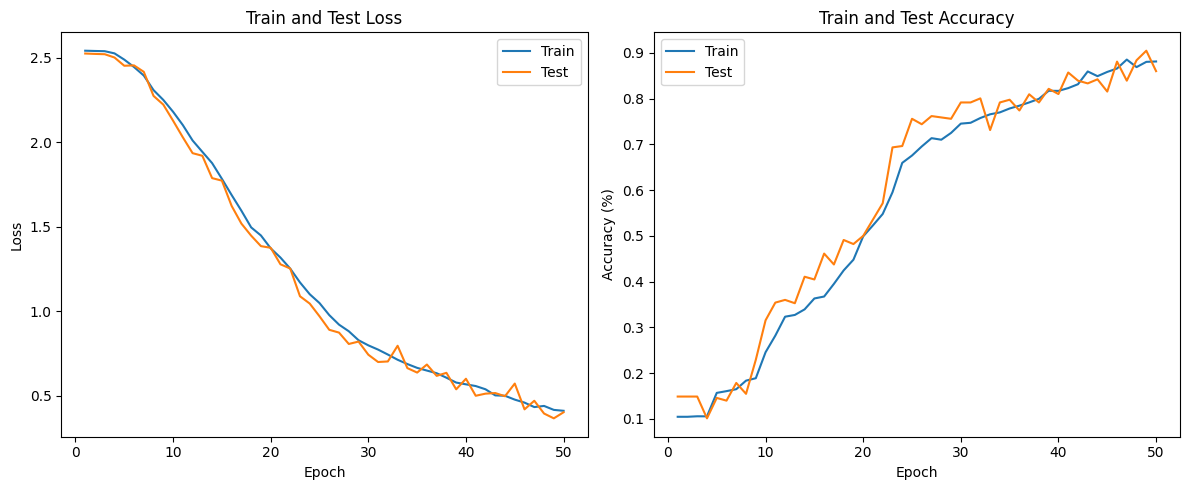

In [99]:
import matplotlib.pyplot as plt

train_losses = results["train_loss"]
train_accuracies = results["train_acc"]
test_losses = results["test_loss"]
test_accuracies = results["test_acc"]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train")
plt.plot(epochs, test_accuracies, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


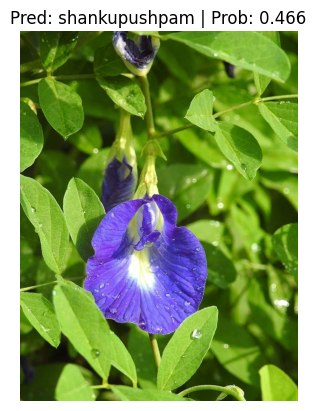

In [93]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = r'/home/rc/Desktop/71CsRRNbO4L._AC_UF1000,1000_QL80_.jpg'
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

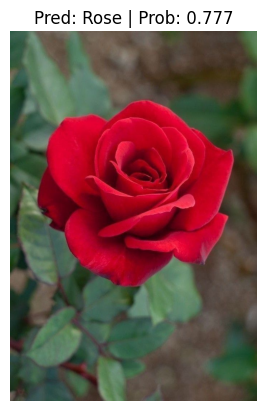

In [96]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = r'/home/rc/Desktop/a2be0553de9c0d6030560c9f4fb62128.jpg'
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)